<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:30] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


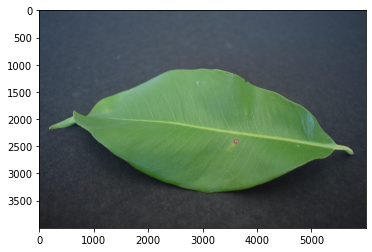

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

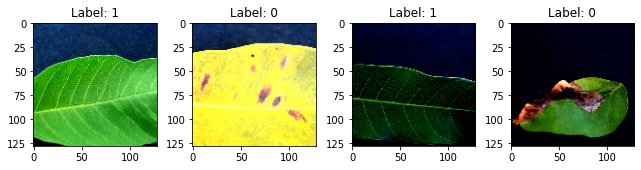

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:36] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:38] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2546315964620698 samples/sec                   batch loss = 0.9988164901733398 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2534728191463809 samples/sec                   batch loss = 0.5497059226036072 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2578666071267643 samples/sec                   batch loss = 0.5851857662200928 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2660012743609859 samples/sec                   batch loss = 0.7595354318618774 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2645031031065888 samples/sec                   batch loss = 1.0141974687576294 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2593881270586682 samples/sec                   batch loss = 0.6213710904121399 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.227635095379587 samples/sec                   batch loss = 0.41131386160850525 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2588223915786865 samples/sec                   batch loss = 0.5314921140670776 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.26145676267309 samples/sec                   batch loss = 0.5027861595153809 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2625536759013687 samples/sec                   batch loss = 0.3910476565361023 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.265264102098266 samples/sec                   batch loss = 0.8459931015968323 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2672935145274593 samples/sec                   batch loss = 0.4758467972278595 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2696460573256318 samples/sec                   batch loss = 0.3514711856842041 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2696128135633495 samples/sec                   batch loss = 0.4777550995349884 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2666671951614041 samples/sec                   batch loss = 0.9301020503044128 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.2685917527399286 samples/sec                   batch loss = 1.1490726470947266 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.262009585041366 samples/sec                   batch loss = 0.7811765670776367 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.25919860999833 samples/sec                   batch loss = 0.6981953978538513 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2600038602470407 samples/sec                   batch loss = 0.7102245092391968 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2621167705904173 samples/sec                   batch loss = 0.2854977548122406 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.2584678259593733 samples/sec                   batch loss = 0.65237957239151 | accuracy = 0.6095238095238096


Epoch[1] Batch[110] Speed: 1.260782190412708 samples/sec                   batch loss = 0.45049601793289185 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2607988659043405 samples/sec                   batch loss = 1.0613797903060913 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.2584113782866264 samples/sec                   batch loss = 0.5073693990707397 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.2586625998666556 samples/sec                   batch loss = 0.44399702548980713 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2617265660075971 samples/sec                   batch loss = 0.5684487223625183 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.259060359973908 samples/sec                   batch loss = 0.8063027262687683 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2596988504804694 samples/sec                   batch loss = 0.5847543478012085 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2589017358693533 samples/sec                   batch loss = 0.9010285139083862 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.266777373293125 samples/sec                   batch loss = 1.7303203344345093 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2687835322986973 samples/sec                   batch loss = 0.35008272528648376 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.2677024007754367 samples/sec                   batch loss = 0.5452330708503723 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.26980922680838 samples/sec                   batch loss = 0.6960061192512512 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2696062803118664 samples/sec                   batch loss = 0.44247645139694214 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.2647072813621243 samples/sec                   batch loss = 0.5998215675354004 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2708720068005208 samples/sec                   batch loss = 0.3328486382961273 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.268539093063312 samples/sec                   batch loss = 0.9335812926292419 | accuracy = 0.6472972972972973


Epoch[1] Batch[190] Speed: 1.270912922185633 samples/sec                   batch loss = 0.4571540355682373 | accuracy = 0.6513157894736842


Epoch[1] Batch[195] Speed: 1.263630512777929 samples/sec                   batch loss = 0.7425100207328796 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.2609171229544087 samples/sec                   batch loss = 0.598501980304718 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.26503332159075 samples/sec                   batch loss = 0.4134098291397095 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2637513958748017 samples/sec                   batch loss = 2.767765998840332 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.268116055955118 samples/sec                   batch loss = 0.5306607484817505 | accuracy = 0.6627906976744186


Epoch[1] Batch[220] Speed: 1.2655787823021303 samples/sec                   batch loss = 0.22641418874263763 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.2641539033498705 samples/sec                   batch loss = 1.0597115755081177 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.2670464912545691 samples/sec                   batch loss = 0.3388839364051819 | accuracy = 0.6641304347826087


Epoch[1] Batch[235] Speed: 1.26951165178312 samples/sec                   batch loss = 1.040856122970581 | accuracy = 0.6638297872340425


Epoch[1] Batch[240] Speed: 1.2727533692595594 samples/sec                   batch loss = 0.5812329649925232 | accuracy = 0.665625


Epoch[1] Batch[245] Speed: 1.2754547716576115 samples/sec                   batch loss = 0.6684643030166626 | accuracy = 0.6683673469387755


Epoch[1] Batch[250] Speed: 1.2672882495633626 samples/sec                   batch loss = 0.5917733311653137 | accuracy = 0.67


Epoch[1] Batch[255] Speed: 1.2746641333261612 samples/sec                   batch loss = 0.5655075311660767 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.2640821816886978 samples/sec                   batch loss = 0.7598353624343872 | accuracy = 0.6663461538461538


Epoch[1] Batch[265] Speed: 1.2587753564714828 samples/sec                   batch loss = 0.6611754894256592 | accuracy = 0.6660377358490566


Epoch[1] Batch[270] Speed: 1.2585576051810767 samples/sec                   batch loss = 0.3288131654262543 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2631560560765704 samples/sec                   batch loss = 0.20457153022289276 | accuracy = 0.6718181818181819


Epoch[1] Batch[280] Speed: 1.2625589015991856 samples/sec                   batch loss = 0.4569099247455597 | accuracy = 0.6723214285714286


Epoch[1] Batch[285] Speed: 1.2685993307217123 samples/sec                   batch loss = 0.8982179760932922 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2664647736796122 samples/sec                   batch loss = 0.21850906312465668 | accuracy = 0.6732758620689655


Epoch[1] Batch[295] Speed: 1.2692484953353809 samples/sec                   batch loss = 0.35295820236206055 | accuracy = 0.6745762711864407


Epoch[1] Batch[300] Speed: 1.2545970702914535 samples/sec                   batch loss = 0.817254364490509 | accuracy = 0.6741666666666667


Epoch[1] Batch[305] Speed: 1.261436181150941 samples/sec                   batch loss = 0.9191144108772278 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2637920444422415 samples/sec                   batch loss = 0.16261038184165955 | accuracy = 0.6733870967741935


Epoch[1] Batch[315] Speed: 1.2621474390705925 samples/sec                   batch loss = 0.6621516942977905 | accuracy = 0.6722222222222223


Epoch[1] Batch[320] Speed: 1.2710543653037611 samples/sec                   batch loss = 0.3327587842941284 | accuracy = 0.675


Epoch[1] Batch[325] Speed: 1.2678428427123554 samples/sec                   batch loss = 0.35252052545547485 | accuracy = 0.6761538461538461


Epoch[1] Batch[330] Speed: 1.2598537020576344 samples/sec                   batch loss = 0.6902957558631897 | accuracy = 0.675


Epoch[1] Batch[335] Speed: 1.2714431349320505 samples/sec                   batch loss = 0.8385865688323975 | accuracy = 0.6746268656716418


Epoch[1] Batch[340] Speed: 1.269414828257051 samples/sec                   batch loss = 0.7558638453483582 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.265899159003172 samples/sec                   batch loss = 0.8364371061325073 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2641448543516969 samples/sec                   batch loss = 1.1216623783111572 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2658905625780041 samples/sec                   batch loss = 0.6246589422225952 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2662422516587282 samples/sec                   batch loss = 0.4880366921424866 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.2646481753669125 samples/sec                   batch loss = 0.5173167586326599 | accuracy = 0.6691780821917809


Epoch[1] Batch[370] Speed: 1.255035168135668 samples/sec                   batch loss = 0.5323762893676758 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.2536266120797777 samples/sec                   batch loss = 1.0433915853500366 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.2450158450474282 samples/sec                   batch loss = 0.2019331306219101 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.2595472520083841 samples/sec                   batch loss = 0.530902624130249 | accuracy = 0.6714285714285714


Epoch[1] Batch[390] Speed: 1.263418309426943 samples/sec                   batch loss = 0.22143736481666565 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2635690330835123 samples/sec                   batch loss = 0.2837640941143036 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2567221823553294 samples/sec                   batch loss = 1.638140320777893 | accuracy = 0.674375


Epoch[1] Batch[405] Speed: 1.2578481229986738 samples/sec                   batch loss = 0.593704342842102 | accuracy = 0.6746913580246914


Epoch[1] Batch[410] Speed: 1.2616951589116066 samples/sec                   batch loss = 0.5300572514533997 | accuracy = 0.6725609756097561


Epoch[1] Batch[415] Speed: 1.2582862297693924 samples/sec                   batch loss = 0.702155590057373 | accuracy = 0.6746987951807228


Epoch[1] Batch[420] Speed: 1.2598941002690673 samples/sec                   batch loss = 0.37285542488098145 | accuracy = 0.6761904761904762


Epoch[1] Batch[425] Speed: 1.255233764358464 samples/sec                   batch loss = 0.7230496406555176 | accuracy = 0.6758823529411765


Epoch[1] Batch[430] Speed: 1.2540225073848619 samples/sec                   batch loss = 0.5515275597572327 | accuracy = 0.6767441860465117


Epoch[1] Batch[435] Speed: 1.2538000256182342 samples/sec                   batch loss = 0.39972761273384094 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.2561507505248743 samples/sec                   batch loss = 0.6627659201622009 | accuracy = 0.6789772727272727


Epoch[1] Batch[445] Speed: 1.2566809518623312 samples/sec                   batch loss = 0.6922868490219116 | accuracy = 0.6792134831460674


Epoch[1] Batch[450] Speed: 1.2593516370459745 samples/sec                   batch loss = 0.4429555833339691 | accuracy = 0.6794444444444444


Epoch[1] Batch[455] Speed: 1.2595239905938935 samples/sec                   batch loss = 0.5356190204620361 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.2602806159663336 samples/sec                   batch loss = 0.4486468732357025 | accuracy = 0.6826086956521739


Epoch[1] Batch[465] Speed: 1.2614254638500282 samples/sec                   batch loss = 0.6971706748008728 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.269729174348365 samples/sec                   batch loss = 0.38587141036987305 | accuracy = 0.6845744680851064


Epoch[1] Batch[475] Speed: 1.2670847682919462 samples/sec                   batch loss = 0.7093268036842346 | accuracy = 0.6857894736842105


Epoch[1] Batch[480] Speed: 1.2670357740985183 samples/sec                   batch loss = 0.6337187886238098 | accuracy = 0.6864583333333333


Epoch[1] Batch[485] Speed: 1.2698917884769154 samples/sec                   batch loss = 0.3680856227874756 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.2665743428876164 samples/sec                   batch loss = 0.43086639046669006 | accuracy = 0.6887755102040817


Epoch[1] Batch[495] Speed: 1.2607059246103505 samples/sec                   batch loss = 0.3431834280490875 | accuracy = 0.6898989898989899


Epoch[1] Batch[500] Speed: 1.2663279821972142 samples/sec                   batch loss = 0.5997738838195801 | accuracy = 0.6905


Epoch[1] Batch[505] Speed: 1.2699625367010436 samples/sec                   batch loss = 0.29278698563575745 | accuracy = 0.6905940594059405


Epoch[1] Batch[510] Speed: 1.2666535198728486 samples/sec                   batch loss = 0.5805785059928894 | accuracy = 0.6916666666666667


Epoch[1] Batch[515] Speed: 1.2654893349745686 samples/sec                   batch loss = 0.4529663622379303 | accuracy = 0.6902912621359223


Epoch[1] Batch[520] Speed: 1.2639190523644632 samples/sec                   batch loss = 1.3362507820129395 | accuracy = 0.6894230769230769


Epoch[1] Batch[525] Speed: 1.2669731015037267 samples/sec                   batch loss = 0.5662833452224731 | accuracy = 0.689047619047619


Epoch[1] Batch[530] Speed: 1.2723549206443583 samples/sec                   batch loss = 0.6040742993354797 | accuracy = 0.6877358490566038


Epoch[1] Batch[535] Speed: 1.2665399211987833 samples/sec                   batch loss = 0.4129054546356201 | accuracy = 0.6892523364485982


Epoch[1] Batch[540] Speed: 1.2682430716773756 samples/sec                   batch loss = 0.45061179995536804 | accuracy = 0.6884259259259259


Epoch[1] Batch[545] Speed: 1.2672924615311403 samples/sec                   batch loss = 0.5935336351394653 | accuracy = 0.6885321100917431


Epoch[1] Batch[550] Speed: 1.2611053566032602 samples/sec                   batch loss = 1.0743299722671509 | accuracy = 0.6886363636363636


Epoch[1] Batch[555] Speed: 1.264051609590063 samples/sec                   batch loss = 0.570009708404541 | accuracy = 0.6891891891891891


Epoch[1] Batch[560] Speed: 1.2645454203536204 samples/sec                   batch loss = 0.4321117699146271 | accuracy = 0.6879464285714286


Epoch[1] Batch[565] Speed: 1.2658024082001391 samples/sec                   batch loss = 0.2816399037837982 | accuracy = 0.6893805309734513


Epoch[1] Batch[570] Speed: 1.2620386344191123 samples/sec                   batch loss = 0.7039345502853394 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2679501590226487 samples/sec                   batch loss = 0.7584052085876465 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2599672399217248 samples/sec                   batch loss = 0.5864435434341431 | accuracy = 0.6892241379310344


Epoch[1] Batch[585] Speed: 1.26577328079578 samples/sec                   batch loss = 0.3394486904144287 | accuracy = 0.6901709401709402


Epoch[1] Batch[590] Speed: 1.2664772976468677 samples/sec                   batch loss = 0.6049838066101074 | accuracy = 0.6894067796610169


Epoch[1] Batch[595] Speed: 1.2657202819086488 samples/sec                   batch loss = 0.3308640122413635 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2628210020754949 samples/sec                   batch loss = 0.14118720591068268 | accuracy = 0.6908333333333333


Epoch[1] Batch[605] Speed: 1.2617745810860042 samples/sec                   batch loss = 0.2968875765800476 | accuracy = 0.6904958677685951


Epoch[1] Batch[610] Speed: 1.263641077228663 samples/sec                   batch loss = 0.28425708413124084 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.2619882260579425 samples/sec                   batch loss = 0.614631712436676 | accuracy = 0.6914634146341463


Epoch[1] Batch[620] Speed: 1.2669012509365525 samples/sec                   batch loss = 0.12746383249759674 | accuracy = 0.6907258064516129


Epoch[1] Batch[625] Speed: 1.2682403873083858 samples/sec                   batch loss = 0.4820134937763214 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2695061762492579 samples/sec                   batch loss = 0.15927015244960785 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2672466100248891 samples/sec                   batch loss = 0.7903750538825989 | accuracy = 0.6909448818897638


Epoch[1] Batch[640] Speed: 1.2663096308713815 samples/sec                   batch loss = 0.3213702440261841 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2702642663824275 samples/sec                   batch loss = 0.8373223543167114 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.2719336744066085 samples/sec                   batch loss = 0.31929072737693787 | accuracy = 0.6915384615384615


Epoch[1] Batch[655] Speed: 1.269000037516595 samples/sec                   batch loss = 0.05020318180322647 | accuracy = 0.6931297709923664


Epoch[1] Batch[660] Speed: 1.2629099775152677 samples/sec                   batch loss = 0.2547743618488312 | accuracy = 0.693939393939394


Epoch[1] Batch[665] Speed: 1.261995250710479 samples/sec                   batch loss = 0.17798349261283875 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2672767625208157 samples/sec                   batch loss = 0.45169517397880554 | accuracy = 0.6944029850746268


Epoch[1] Batch[675] Speed: 1.264897220601885 samples/sec                   batch loss = 0.3779717981815338 | accuracy = 0.6944444444444444


Epoch[1] Batch[680] Speed: 1.2617909981467847 samples/sec                   batch loss = 0.7248152494430542 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.2593214823877785 samples/sec                   batch loss = 0.7977240681648254 | accuracy = 0.6945255474452555


Epoch[1] Batch[690] Speed: 1.2669156012640448 samples/sec                   batch loss = 0.9257230758666992 | accuracy = 0.6945652173913044


Epoch[1] Batch[695] Speed: 1.267364165004958 samples/sec                   batch loss = 0.2690606713294983 | accuracy = 0.6964028776978417


Epoch[1] Batch[700] Speed: 1.2677319044122652 samples/sec                   batch loss = 1.1061232089996338 | accuracy = 0.6957142857142857


Epoch[1] Batch[705] Speed: 1.261915516005632 samples/sec                   batch loss = 0.48699751496315 | accuracy = 0.6950354609929078


Epoch[1] Batch[710] Speed: 1.2630924353880864 samples/sec                   batch loss = 0.1717686951160431 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.266089074260598 samples/sec                   batch loss = 0.4298040270805359 | accuracy = 0.6944055944055944


Epoch[1] Batch[720] Speed: 1.2692243941228034 samples/sec                   batch loss = 0.8766570687294006 | accuracy = 0.6934027777777778


Epoch[1] Batch[725] Speed: 1.267647899291858 samples/sec                   batch loss = 0.47777149081230164 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.264365305756251 samples/sec                   batch loss = 0.6963172554969788 | accuracy = 0.6941780821917808


Epoch[1] Batch[735] Speed: 1.2688041623682387 samples/sec                   batch loss = 0.48204997181892395 | accuracy = 0.6948979591836735


Epoch[1] Batch[740] Speed: 1.2672422069233271 samples/sec                   batch loss = 0.389413982629776 | accuracy = 0.6949324324324324


Epoch[1] Batch[745] Speed: 1.2678852879741 samples/sec                   batch loss = 0.5554413795471191 | accuracy = 0.6946308724832215


Epoch[1] Batch[750] Speed: 1.263432105236206 samples/sec                   batch loss = 0.6066656708717346 | accuracy = 0.6943333333333334


Epoch[1] Batch[755] Speed: 1.2710715062272384 samples/sec                   batch loss = 0.684596836566925 | accuracy = 0.6937086092715232


Epoch[1] Batch[760] Speed: 1.26615060832482 samples/sec                   batch loss = 0.45990973711013794 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2728183531716302 samples/sec                   batch loss = 0.4739852547645569 | accuracy = 0.6937908496732026


Epoch[1] Batch[770] Speed: 1.2714541194901396 samples/sec                   batch loss = 0.5298696756362915 | accuracy = 0.6931818181818182


Epoch[1] Batch[775] Speed: 1.2683459490941464 samples/sec                   batch loss = 0.28740671277046204 | accuracy = 0.6941935483870968


Epoch[1] Batch[780] Speed: 1.2678989898730357 samples/sec                   batch loss = 0.7749555110931396 | accuracy = 0.694551282051282


Epoch[1] Batch[785] Speed: 1.2625823702663836 samples/sec                   batch loss = 0.4479374289512634 | accuracy = 0.6945859872611465


[Epoch 1] training: accuracy=0.6947969543147208
[Epoch 1] time cost: 650.4565031528473
[Epoch 1] validation: validation accuracy=0.7277777777777777


Epoch[2] Batch[5] Speed: 1.2679937614633414 samples/sec                   batch loss = 0.5326142311096191 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2744511126634614 samples/sec                   batch loss = 1.179918646812439 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2687615596135942 samples/sec                   batch loss = 0.2505807876586914 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2725978403662352 samples/sec                   batch loss = 0.2173740714788437 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2685579886556368 samples/sec                   batch loss = 0.40912410616874695 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2657080593717094 samples/sec                   batch loss = 0.4793204665184021 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2659374622721236 samples/sec                   batch loss = 0.39249271154403687 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.266706405667753 samples/sec                   batch loss = 0.45071667432785034 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2667501138980715 samples/sec                   batch loss = 0.31038525700569153 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2641993408042984 samples/sec                   batch loss = 0.21477504074573517 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2676273068053037 samples/sec                   batch loss = 0.5309951305389404 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2684888354459167 samples/sec                   batch loss = 0.4541204571723938 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2653953191308986 samples/sec                   batch loss = 0.7568550109863281 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2695783225981427 samples/sec                   batch loss = 0.3550878167152405 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.269358546765466 samples/sec                   batch loss = 0.5439404249191284 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2701750210052765 samples/sec                   batch loss = 0.32379576563835144 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.270714916199941 samples/sec                   batch loss = 0.9251582026481628 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2669326307411275 samples/sec                   batch loss = 0.4078011214733124 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2684111549794457 samples/sec                   batch loss = 0.35355234146118164 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2710126704930143 samples/sec                   batch loss = 0.4662030041217804 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2683406753817692 samples/sec                   batch loss = 0.6129544973373413 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2742258723686724 samples/sec                   batch loss = 0.7524881958961487 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2701967541769001 samples/sec                   batch loss = 0.19792242348194122 | accuracy = 0.7608695652173914


Epoch[2] Batch[120] Speed: 1.2715788171657367 samples/sec                   batch loss = 0.7613551020622253 | accuracy = 0.7604166666666666


Epoch[2] Batch[125] Speed: 1.2720438062075272 samples/sec                   batch loss = 0.5312681198120117 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.2685815849572373 samples/sec                   batch loss = 0.6985594034194946 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.2726297926103616 samples/sec                   batch loss = 0.24751730263233185 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2666835485165189 samples/sec                   batch loss = 0.45055902004241943 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2730570062989597 samples/sec                   batch loss = 0.4714880585670471 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.266806833888251 samples/sec                   batch loss = 0.9379708170890808 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2727854258727538 samples/sec                   batch loss = 0.4405841827392578 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2700863650637102 samples/sec                   batch loss = 0.4175991415977478 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2776109128209503 samples/sec                   batch loss = 0.30928146839141846 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2778570117968515 samples/sec                   batch loss = 0.7950056195259094 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2691022697780012 samples/sec                   batch loss = 0.40902605652809143 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.269115805988225 samples/sec                   batch loss = 0.5574085116386414 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2639528556250226 samples/sec                   batch loss = 1.1199294328689575 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2609145642738357 samples/sec                   batch loss = 0.6485058665275574 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.259711619329165 samples/sec                   batch loss = 0.3066106140613556 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.2635865437184244 samples/sec                   batch loss = 0.6231971383094788 | accuracy = 0.7575


Epoch[2] Batch[205] Speed: 1.2642493543572146 samples/sec                   batch loss = 0.2736784517765045 | accuracy = 0.7597560975609756


Epoch[2] Batch[210] Speed: 1.2621933971064945 samples/sec                   batch loss = 0.49849504232406616 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.2632107426570092 samples/sec                   batch loss = 0.28929704427719116 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.2698881359293408 samples/sec                   batch loss = 0.3499431908130646 | accuracy = 0.7545454545454545


Epoch[2] Batch[225] Speed: 1.2728430739056569 samples/sec                   batch loss = 0.4818926453590393 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2726955362620251 samples/sec                   batch loss = 0.598767876625061 | accuracy = 0.7532608695652174


Epoch[2] Batch[235] Speed: 1.2759264816626241 samples/sec                   batch loss = 0.5094321966171265 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2699858007468876 samples/sec                   batch loss = 0.6588162183761597 | accuracy = 0.7541666666666667


Epoch[2] Batch[245] Speed: 1.2668473922738632 samples/sec                   batch loss = 0.48826533555984497 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.2628957177870517 samples/sec                   batch loss = 0.18292830884456635 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.266462766043775 samples/sec                   batch loss = 0.9606804847717285 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.2625324885152938 samples/sec                   batch loss = 0.9170324802398682 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.26587231944028 samples/sec                   batch loss = 0.2985179126262665 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2698028837482689 samples/sec                   batch loss = 0.7293097972869873 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.2743436610783223 samples/sec                   batch loss = 1.091275930404663 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2686103621228386 samples/sec                   batch loss = 0.23998862504959106 | accuracy = 0.7544642857142857


Epoch[2] Batch[285] Speed: 1.2715553983489924 samples/sec                   batch loss = 0.7607854604721069 | accuracy = 0.7552631578947369


Epoch[2] Batch[290] Speed: 1.2659387040627756 samples/sec                   batch loss = 0.2066473364830017 | accuracy = 0.7543103448275862


Epoch[2] Batch[295] Speed: 1.2697275407297877 samples/sec                   batch loss = 0.7739110589027405 | accuracy = 0.7550847457627119


Epoch[2] Batch[300] Speed: 1.267921411801017 samples/sec                   batch loss = 0.34907934069633484 | accuracy = 0.7583333333333333


Epoch[2] Batch[305] Speed: 1.2636899996007944 samples/sec                   batch loss = 0.26426494121551514 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.251491595861366 samples/sec                   batch loss = 0.5083116888999939 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2567742420704648 samples/sec                   batch loss = 0.22834178805351257 | accuracy = 0.7563492063492063


Epoch[2] Batch[320] Speed: 1.2600924391371247 samples/sec                   batch loss = 0.49047747254371643 | accuracy = 0.75625


Epoch[2] Batch[325] Speed: 1.2671325221382808 samples/sec                   batch loss = 0.3212847113609314 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.2662087080860087 samples/sec                   batch loss = 0.14921540021896362 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.267687553685427 samples/sec                   batch loss = 0.7435619831085205 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.268523938629546 samples/sec                   batch loss = 0.34494927525520325 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.264132852722394 samples/sec                   batch loss = 0.2810448706150055 | accuracy = 0.7543478260869565


Epoch[2] Batch[350] Speed: 1.2633475273925714 samples/sec                   batch loss = 0.49478256702423096 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2623848616292914 samples/sec                   batch loss = 0.2808685004711151 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.2656799866259247 samples/sec                   batch loss = 0.34596511721611023 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.260688588454234 samples/sec                   batch loss = 0.532239556312561 | accuracy = 0.7554794520547945


Epoch[2] Batch[370] Speed: 1.264347964095904 samples/sec                   batch loss = 0.6627056002616882 | accuracy = 0.754054054054054


Epoch[2] Batch[375] Speed: 1.2774537082228827 samples/sec                   batch loss = 1.269100308418274 | accuracy = 0.7533333333333333


Epoch[2] Batch[380] Speed: 1.2699479250088639 samples/sec                   batch loss = 0.20107245445251465 | accuracy = 0.7532894736842105


Epoch[2] Batch[385] Speed: 1.2735688040160966 samples/sec                   batch loss = 0.5710790157318115 | accuracy = 0.7545454545454545


Epoch[2] Batch[390] Speed: 1.2700892495524805 samples/sec                   batch loss = 1.0017286539077759 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2702159876924568 samples/sec                   batch loss = 0.2790067791938782 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2746061265547477 samples/sec                   batch loss = 0.6756133437156677 | accuracy = 0.75125


Epoch[2] Batch[405] Speed: 1.2750723636240378 samples/sec                   batch loss = 0.5625537633895874 | accuracy = 0.75


Epoch[2] Batch[410] Speed: 1.2721350506720572 samples/sec                   batch loss = 0.4097660779953003 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2743123002480232 samples/sec                   batch loss = 1.4133645296096802 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.266984678722287 samples/sec                   batch loss = 0.4688520133495331 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.2637625335125895 samples/sec                   batch loss = 0.4563189446926117 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.2644825173618217 samples/sec                   batch loss = 0.8419594764709473 | accuracy = 0.747093023255814


Epoch[2] Batch[435] Speed: 1.262008066156444 samples/sec                   batch loss = 0.2558814585208893 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.2659715646390632 samples/sec                   batch loss = 0.4403263330459595 | accuracy = 0.7471590909090909


Epoch[2] Batch[445] Speed: 1.2730919763532869 samples/sec                   batch loss = 0.6801609992980957 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.2728573660180669 samples/sec                   batch loss = 0.36656877398490906 | accuracy = 0.7466666666666667


Epoch[2] Batch[455] Speed: 1.2646986057814007 samples/sec                   batch loss = 0.524378776550293 | accuracy = 0.7483516483516484


Epoch[2] Batch[460] Speed: 1.2663921204356086 samples/sec                   batch loss = 0.5471570491790771 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2636992324577838 samples/sec                   batch loss = 0.5102379322052002 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.2648549751653744 samples/sec                   batch loss = 0.37484675645828247 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2633550428505056 samples/sec                   batch loss = 0.4167328476905823 | accuracy = 0.7494736842105263


Epoch[2] Batch[480] Speed: 1.2656678603487743 samples/sec                   batch loss = 0.21744199097156525 | accuracy = 0.75


Epoch[2] Batch[485] Speed: 1.2709782959973903 samples/sec                   batch loss = 0.8049353361129761 | accuracy = 0.75


Epoch[2] Batch[490] Speed: 1.265921892334567 samples/sec                   batch loss = 0.14002598822116852 | accuracy = 0.7515306122448979


Epoch[2] Batch[495] Speed: 1.265080539357584 samples/sec                   batch loss = 0.4120504558086395 | accuracy = 0.7535353535353535


Epoch[2] Batch[500] Speed: 1.265259712762518 samples/sec                   batch loss = 0.3277648091316223 | accuracy = 0.753


Epoch[2] Batch[505] Speed: 1.272670531635207 samples/sec                   batch loss = 0.5272068381309509 | accuracy = 0.7524752475247525


Epoch[2] Batch[510] Speed: 1.26580813833912 samples/sec                   batch loss = 0.6906757950782776 | accuracy = 0.7519607843137255


Epoch[2] Batch[515] Speed: 1.2685084009151713 samples/sec                   batch loss = 0.7367159128189087 | accuracy = 0.75


Epoch[2] Batch[520] Speed: 1.2681460581286723 samples/sec                   batch loss = 0.5653080344200134 | accuracy = 0.7495192307692308


Epoch[2] Batch[525] Speed: 1.2664296887696829 samples/sec                   batch loss = 0.2791009545326233 | accuracy = 0.75


Epoch[2] Batch[530] Speed: 1.2708413941883066 samples/sec                   batch loss = 0.49023544788360596 | accuracy = 0.7509433962264151


Epoch[2] Batch[535] Speed: 1.2677173440042775 samples/sec                   batch loss = 0.36607441306114197 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.271560602455944 samples/sec                   batch loss = 0.2629012167453766 | accuracy = 0.7513888888888889


Epoch[2] Batch[545] Speed: 1.2720483391858783 samples/sec                   batch loss = 0.4085460305213928 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2736301971197668 samples/sec                   batch loss = 0.5076457858085632 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.267764474956779 samples/sec                   batch loss = 0.2584509551525116 | accuracy = 0.7545045045045045


Epoch[2] Batch[560] Speed: 1.2675156401347536 samples/sec                   batch loss = 0.3870871663093567 | accuracy = 0.7526785714285714


Epoch[2] Batch[565] Speed: 1.2677727136538277 samples/sec                   batch loss = 0.2408091425895691 | accuracy = 0.7517699115044247


Epoch[2] Batch[570] Speed: 1.269407624715972 samples/sec                   batch loss = 0.1862938106060028 | accuracy = 0.7526315789473684


Epoch[2] Batch[575] Speed: 1.2690334411762125 samples/sec                   batch loss = 0.41746535897254944 | accuracy = 0.7526086956521739


Epoch[2] Batch[580] Speed: 1.2699145693136062 samples/sec                   batch loss = 0.2910468280315399 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.2703720892161208 samples/sec                   batch loss = 0.704044759273529 | accuracy = 0.7525641025641026


Epoch[2] Batch[590] Speed: 1.2726849164163165 samples/sec                   batch loss = 0.22405631840229034 | accuracy = 0.7538135593220339


Epoch[2] Batch[595] Speed: 1.2716063811580633 samples/sec                   batch loss = 0.8296110033988953 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.270896074355061 samples/sec                   batch loss = 0.11231441050767899 | accuracy = 0.75375


Epoch[2] Batch[605] Speed: 1.272464160310369 samples/sec                   batch loss = 0.2149042934179306 | accuracy = 0.7541322314049587


Epoch[2] Batch[610] Speed: 1.2693240696137778 samples/sec                   batch loss = 0.12486738711595535 | accuracy = 0.7545081967213115


Epoch[2] Batch[615] Speed: 1.2686151584440386 samples/sec                   batch loss = 0.317566841840744 | accuracy = 0.7544715447154472


Epoch[2] Batch[620] Speed: 1.2690916138156358 samples/sec                   batch loss = 0.41818851232528687 | accuracy = 0.7540322580645161


Epoch[2] Batch[625] Speed: 1.2668339044092984 samples/sec                   batch loss = 0.8827716112136841 | accuracy = 0.754


Epoch[2] Batch[630] Speed: 1.261303318454802 samples/sec                   batch loss = 0.22505787014961243 | accuracy = 0.7547619047619047


Epoch[2] Batch[635] Speed: 1.2641109455740072 samples/sec                   batch loss = 0.20887014269828796 | accuracy = 0.7555118110236221


Epoch[2] Batch[640] Speed: 1.2642346833048872 samples/sec                   batch loss = 0.5843920111656189 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2626042244656692 samples/sec                   batch loss = 0.2911774218082428 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2723615787091154 samples/sec                   batch loss = 0.7487313747406006 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.272915020568045 samples/sec                   batch loss = 1.096926212310791 | accuracy = 0.7538167938931297


Epoch[2] Batch[660] Speed: 1.267083332861308 samples/sec                   batch loss = 0.46518900990486145 | accuracy = 0.7534090909090909


Epoch[2] Batch[665] Speed: 1.2679252446885863 samples/sec                   batch loss = 0.43189549446105957 | accuracy = 0.7537593984962406


Epoch[2] Batch[670] Speed: 1.2684261149221452 samples/sec                   batch loss = 0.5026153922080994 | accuracy = 0.7526119402985074


Epoch[2] Batch[675] Speed: 1.2660933738067468 samples/sec                   batch loss = 0.2465149313211441 | accuracy = 0.7533333333333333


Epoch[2] Batch[680] Speed: 1.2689048275394712 samples/sec                   batch loss = 0.6078013181686401 | accuracy = 0.7529411764705882


Epoch[2] Batch[685] Speed: 1.2669902282078522 samples/sec                   batch loss = 0.29484397172927856 | accuracy = 0.7518248175182481


Epoch[2] Batch[690] Speed: 1.2634872914862372 samples/sec                   batch loss = 0.5018808841705322 | accuracy = 0.7507246376811594


Epoch[2] Batch[695] Speed: 1.2672102374948158 samples/sec                   batch loss = 0.37013354897499084 | accuracy = 0.7514388489208633


Epoch[2] Batch[700] Speed: 1.2670545292405866 samples/sec                   batch loss = 0.43952223658561707 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.2635280182243325 samples/sec                   batch loss = 0.37031084299087524 | accuracy = 0.75177304964539


Epoch[2] Batch[710] Speed: 1.263601580411799 samples/sec                   batch loss = 0.6661653518676758 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.2676641821967445 samples/sec                   batch loss = 0.195677250623703 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.2661119099622413 samples/sec                   batch loss = 0.3098277151584625 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.2644664113899846 samples/sec                   batch loss = 0.30883216857910156 | accuracy = 0.7524137931034482


Epoch[2] Batch[730] Speed: 1.2700385806061392 samples/sec                   batch loss = 0.25810664892196655 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.2732741028549674 samples/sec                   batch loss = 0.26907357573509216 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.2646475080726995 samples/sec                   batch loss = 0.6310345530509949 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2731997000578348 samples/sec                   batch loss = 0.4701583683490753 | accuracy = 0.7516778523489933


Epoch[2] Batch[750] Speed: 1.2647793600194799 samples/sec                   batch loss = 0.3724707067012787 | accuracy = 0.7523333333333333


Epoch[2] Batch[755] Speed: 1.268544080677669 samples/sec                   batch loss = 0.4994697868824005 | accuracy = 0.7526490066225165


Epoch[2] Batch[760] Speed: 1.2694393209082673 samples/sec                   batch loss = 0.14462855458259583 | accuracy = 0.7536184210526315


Epoch[2] Batch[765] Speed: 1.2648819623308722 samples/sec                   batch loss = 0.5375846028327942 | accuracy = 0.7532679738562091


Epoch[2] Batch[770] Speed: 1.2639475231595796 samples/sec                   batch loss = 0.2699018716812134 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.2609939829782661 samples/sec                   batch loss = 0.4198682904243469 | accuracy = 0.7541935483870967


Epoch[2] Batch[780] Speed: 1.267716673467229 samples/sec                   batch loss = 0.48017042875289917 | accuracy = 0.7541666666666667


Epoch[2] Batch[785] Speed: 1.2677034544531052 samples/sec                   batch loss = 0.8358374834060669 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7538071065989848
[Epoch 2] time cost: 639.386316537857
[Epoch 2] validation: validation accuracy=0.7844444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)